In [1]:
import anndata
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from harmonypy import run_harmony
import numpy as np
from ALLCools.mcds.MCDS import MCDS

## RNA HVG

In [5]:
rna_adata = anndata.read_h5ad('rna_adata.h5ad')
rna_adata

AnnData object with n_obs × n_vars = 3898 × 60606
    obs: 'Technology', 'Brain Region', 'AD Index', 'Total Methylome Reads', 'Overall Adjusted mCG%', 'Overall Adjusted mCH%', 'Overall mCCC%', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'MajorCluster', 'ClusterAnno', 'MajorType', 'SubClusterInternalID', 'subumap_0', 'subumap_1', 'subtsne_0', 'subtsne_1', 'SubMarker', 'SubClusterAnno', 'MajorMarker', 'Individual ID', 'Individual Label', 'Individual Age', 'm3c_cluster', 'cell_id'

In [6]:
sc.pp.filter_genes(rna_adata, min_cells=10)
sc.pp.filter_cells(rna_adata, min_genes=200)

In [7]:
rna_adata

AnnData object with n_obs × n_vars = 3896 × 25109
    obs: 'Technology', 'Brain Region', 'AD Index', 'Total Methylome Reads', 'Overall Adjusted mCG%', 'Overall Adjusted mCH%', 'Overall mCCC%', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'MajorCluster', 'ClusterAnno', 'MajorType', 'SubClusterInternalID', 'subumap_0', 'subumap_1', 'subtsne_0', 'subtsne_1', 'SubMarker', 'SubClusterAnno', 'MajorMarker', 'Individual ID', 'Individual Label', 'Individual Age', 'm3c_cluster', 'cell_id', 'n_genes'
    var: 'n_cells'

In [8]:
sc.pp.normalize_total(rna_adata, target_sum=1e6)
sc.pp.log1p(rna_adata)

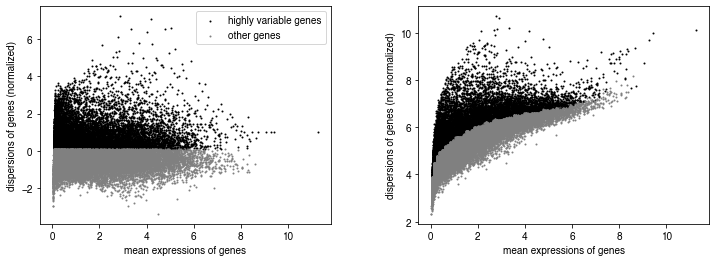

In [9]:
sc.pp.highly_variable_genes(rna_adata,
                            n_bins=100,
                            min_mean=0,
                            max_mean=8,
                            n_top_genes=10000)
sc.pl.highly_variable_genes(rna_adata)

In [10]:
with open('rna_hvg_rank.txt', 'w') as f:
    for gene in rna_adata.var.sort_values('dispersions_norm',
                                          ascending=False).index:
        f.write(gene + '\n')

## HmCH HVG

Feature gene mean cov across cells added in MCDS.coords['gene_cov_mean'].
Before cov mean filter: 60606 gene
 After cov mean filter: 40061 gene 66.1%


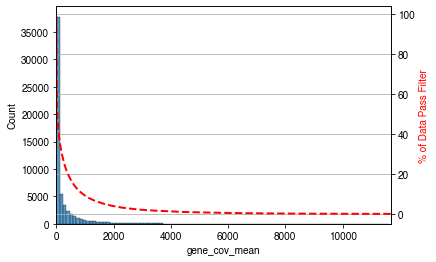

In [7]:
mcds = MCDS.open('../mCTN/dataset/mCTN-*.new.mcds')
del mcds['chrom100k_da']
del mcds['chrom10k_da']
del mcds['rna_da']
del mcds['new_rna_da']

mcds.add_feature_cov_mean(var_dim='gene')
mcds = mcds.filter_feature_by_cov_mean(
    var_dim='gene',
    min_cov=10,  # minimum coverage
    max_cov=99999999  # Maximum coverage
)

mcds = mcds.sel(mc_type=['HCHN'])
mcds.load()
mcds = mcds.sel(cell=rna_adata.obs['cell_id'].values)

In [8]:
mcds.add_mc_rate(var_dim='gene', normalize_per_cell=True, clip_norm_value=10)

Total Feature Number:     40061
Highly Variable Feature:  5000 (12.5%)


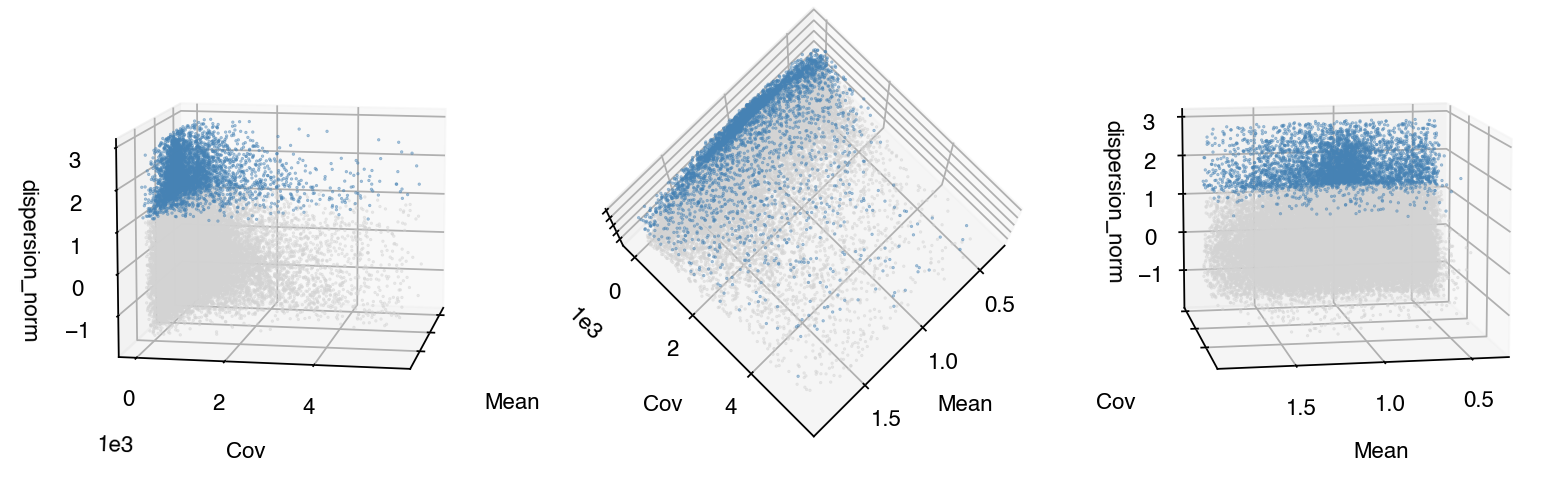

In [9]:
mch_hvf = mcds.calculate_hvf(var_dim='gene',
                             mc_type='HCHN',
                             min_mean=0,
                             max_mean=5,
                             n_top_feature=10000,
                             bin_min_features=5,
                             mean_binsize=0.05,
                             cov_binsize=100)

In [13]:
with open('mch_hvg_rank.txt', 'w') as f:
    for gene in mch_hvf.sort_values('dispersion_norm', ascending=False).index:
        f.write(gene + '\n')